In [1]:
import torch
import numpy as np
import torch.utils
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/saverio/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [2]:
SAMPLING_FREQUENCY = 100000 #Hz
WINDOW_SIZE = 35000

TARGETS = 3

In [ ]:
# This cell tries to import the whole dataset... 
x_windows = []
y_windows = []

# Extracting Y labels
with open("../data/dataset_y", "r") as y:
    y_line = y.readlines()
    y_windows = [int(i.strip()) for i in y_line]
    print("First Class:", y_windows.count(1), "samples")
    print("Second Class:", y_windows.count(2), "samples")
    print("Third Class:", y_windows.count(3), "samples")

with open("../data/dataset_X", "r") as X:
    for k, line in enumerate(X):
        x_windows.append([int(i.strip()) for i in line.split(",")])
        print(k)



In [3]:
# This cell tries to import only a subset of dataset
x_windows = []
y_windows = []

count = 1000

for target in range(1, 4):
    print("Target:", target)
    with open(f"../data/data_{target}", "r") as file:
        for i in range(count):
            line = file.readline()
            x_windows.append([int(j.strip()) for j in line.split(",")])
            y_windows.append(target - 1)

print(len(x_windows))
print(len(y_windows))

Target: 1
Target: 2
Target: 3
3000
3000


In [4]:
x_windows = np.asarray(x_windows)
y_windows = np.asarray(y_windows)
print("x_windows shape: ", x_windows.shape) # Each window of 16,896 samples can be used to create a spectrogram 
print("y_windows shape: ", y_windows.shape) # Corresponding label for each window

x_windows shape:  (3000, 35000)
y_windows shape:  (3000,)


In [5]:
def to_categorical(x, n_classes):
    return np.eye(n_classes, dtype='uint8')[x]

In [6]:
y_features_hot = to_categorical(y_windows, n_classes=TARGETS)

print('The shape of the one-hot encoded labels np array is: ' , y_features_hot.shape)

The shape of the one-hot encoded labels np array is:  (3000, 3)


In [7]:
#x_train, x_test, y_train, y_test = torch.utils.data.random_split(full_dataset, [train_size, test_size])
x_train, x_test, y_train, y_test = train_test_split(x_windows,
                                                    y_features_hot,
                                                    test_size=0.24,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (1710, 35000)
Validation samples: (570, 35000)
Test samples: (720, 35000)


In [8]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
KERNEL_SIZE = 64
POOL_FACT = 2
STRIDE_FACT = KERNEL_SIZE // 4
CHANNEL_COUNT = 16
use_avg_pool = True
model = torch.nn.Sequential() 
output_dim = 35000
model.append(torch.nn.Conv1d(in_channels = 1, out_channels = CHANNEL_COUNT, kernel_size = KERNEL_SIZE, stride=STRIDE_FACT)) #16x16896 - 512 + 1 
output_dim = (output_dim - KERNEL_SIZE) // STRIDE_FACT + 1
model.append(torch.nn.ReLU()) 
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Conv1d(in_channels = CHANNEL_COUNT, out_channels=CHANNEL_COUNT, kernel_size=KERNEL_SIZE // 2, stride=STRIDE_FACT // 2)) #16x7681
output_dim = (output_dim - KERNEL_SIZE // 2) // (STRIDE_FACT // 2)+ 1
model.append(torch.nn.ReLU())
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = int(output_dim) * CHANNEL_COUNT, out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))
#model.append(torch.nn.Softmax(-1))

# Print model summary
#model.summary()
print(count_parameters(model))

opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

541991


In [14]:
x_train_r = x_train.reshape(x_train.shape[0], 1, -1)
print(x_train_r.shape)
x_val_r = x_val.reshape(x_val.shape[0], 1, -1)
print(x_val_r.shape)
x_test_r = x_test.reshape(x_test.shape[0], 1, -1)
print(x_test_r.shape)

(1710, 1, 35000)
(570, 1, 35000)
(720, 1, 35000)


In [11]:

def validate(model, criterion, val_input, val_target, device="cpu"):
    output = model(val_input.float().to(device))
    loss = criterion(output, val_target.float().to(device))
    return loss.item()


def train(model, criterion, optimizer, train_input, train_target, val_input, val_target, num_epochs, mini_batch_size, device="cpu"):
    train_input, train_target = train_input.float().to(device), train_target.float().to(device)
    loss_history = {"train_loss":[], "val_loss":[]}
    for e in range(num_epochs):
        print(f"Epoch: {e}")
        avg_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size).float().to(device))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size).float().to(device))
            avg_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            validate_loss = validate(model, criterion, val_input, val_target)
        avg_loss /= (train_input.size(0) // mini_batch_size)
        loss_history["train_loss"].append(avg_loss)
        loss_history["val_loss"].append(validate_loss)
        print("Train Loss:", avg_loss)
        print("Val Loss:", validate_loss)
    return loss_history

In [19]:
history = train(model, criterion, opt, torch.Tensor(x_train_r), torch.Tensor(y_train), torch.Tensor(x_val_r), torch.Tensor(y_val), num_epochs=100, mini_batch_size=x_train_r.shape[0] // 5)

Epoch: 0
Train Loss: 5595.631474304199
Val Loss: 1.1031721830368042
Epoch: 1
Train Loss: 1.1000828504562379
Val Loss: 1.1236262321472168
Epoch: 2
Train Loss: 1.1098909378051758
Val Loss: 1.1221673488616943
Epoch: 3
Train Loss: 1.1085862874984742
Val Loss: 1.1194268465042114
Epoch: 4
Train Loss: 1.1061869144439698
Val Loss: 1.1152408123016357
Epoch: 5
Train Loss: 1.1031871080398559
Val Loss: 1.1102447509765625
Epoch: 6
Train Loss: 1.1006292343139648
Val Loss: 1.1059964895248413
Epoch: 7
Train Loss: 1.0994500398635865
Val Loss: 1.1029589176177979
Epoch: 8
Train Loss: 1.0990732908248901
Val Loss: 1.101159691810608
Epoch: 9
Train Loss: 1.0987315416336059
Val Loss: 1.100487232208252
Epoch: 10
Train Loss: 1.0985193967819213
Val Loss: 1.1003801822662354
Epoch: 11
Train Loss: 1.0984703540802
Val Loss: 1.100256323814392
Epoch: 12
Train Loss: 1.0984578847885131
Val Loss: 1.0999807119369507
Epoch: 13
Train Loss: 1.0984513282775878
Val Loss: 1.0996981859207153
Epoch: 14
Train Loss: 1.0984646081924

KeyboardInterrupt: 

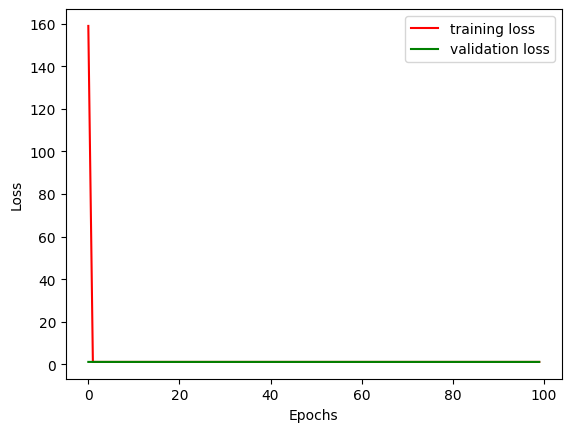

In [36]:

train_loss = history['train_loss']
val_loss = history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(0, len(train_loss)), train_loss, color='r', label='training loss')
plt.plot(np.arange(0, len(val_loss)), val_loss, color='g', label='validation loss')
plt.legend()

In [37]:

def evaluate(model, x_test, y_test):
    y_pred = model(x_test).detach()
    res = np.argmax(y_pred, axis = 1) 
    
    target = np.argmax(y_test, axis = 1)
    train_acc = torch.sum(res == target) / x_test.size(0)

    return train_acc

In [38]:

print('Evaluate model:')
#results = model.evaluate(x_test_r, y_test)
accuracy = evaluate(model, torch.Tensor(x_test_r), torch.Tensor(y_test))
#print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

Evaluate model:
Test accuracy: 33.47%


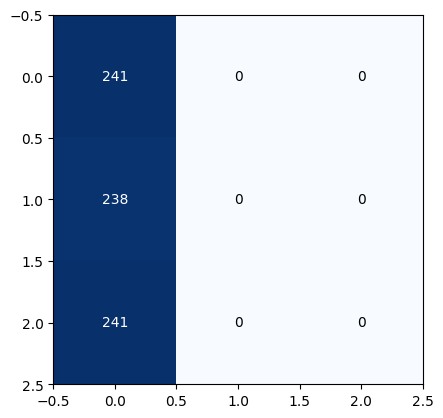

In [39]:

# Plot a confusion matrix
y_pred = model(torch.Tensor(x_test_r)).detach()

y_pred_class_n = np.argmax(y_pred, axis=1)
y_true_class_n = np.argmax(y_test, axis=1)

#accuracy = accuracy_score(y_true_class_n, y_pred_class_n)
#np.set_printoptions(precision=2)
#print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_n, y_pred_class_n, labels=[0,1,2])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)